In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set(rc={'text.usetex' : True})

FAST_MODEL = True

CSV_DIR = '../results/gpu'
all_files = [os.path.join(CSV_DIR, file) for file in os.listdir(CSV_DIR)]
df_list = [pd.read_csv(file) for file in all_files]
df = pd.concat(df_list, ignore_index=True)

df = df.loc[df['3mm'] == FAST_MODEL]
df['rank_factor'] = df['rank_factor'].astype('category')
df['rank_factor'] = df['rank_factor'].cat.add_categories(['Original'])
df.loc[df['apply_tucker'] == False, 'rank_factor'] = 'Original'

df['device_name'] = df['device_name'].astype('category')
new_labels = {
    'NVIDIA GeForce RTX 3090': 'RTX 3090', 
    'NVIDIA GeForce GTX 1080': 'GTX 1080', 
    'NVIDIA A100-SXM4-40GB': 'A100', 
    'NVIDIA GeForce RTX 3060': 'RTX 3060', 
    'NVIDIA GeForce GTX 1660': 'GTX 1660', 
    'NVIDIA RTX A6000': 'A6000', 
    'GeForce RTX 2080 Ti': 'RTX 2080 Ti', 
    'NVIDIA GeForce RTX 2070 SUPER': 'RTX 2070 SUPER', 
}
df['device_name'] = df['device_name'].cat.rename_categories(new_labels)
new_order = ['GTX 1080', 'GTX 1660', 'RTX 2070 SUPER', 'RTX 2080 Ti', 'RTX 3060', 'RTX 3090', 'A6000', 'A100']
df['device_name'] = df['device_name'].cat.reorder_categories(new_order, ordered=True)

df.head()

,batch_size,device,load_params,apply_tucker,autocast,compile,eval_passes,ckpt_path,save_model,load_model,...,rank_mode,rank_factor,rank_min,decompose,verbose,g_flops,m_params,exec_time_mean,exec_time_std,device_name
0,1,cuda,False,True,True,True,10,.checkpoints/model.ckpt,False,False,...,relative,0.05,8,False,False,19.544361,0.151435,30.277402,1.907339,RTX 2080 Ti
2,1,cuda,False,True,True,False,10,.checkpoints/model.ckpt,False,False,...,relative,0.05,8,False,False,19.544361,0.151435,33.430724,0.057236,RTX 2080 Ti
4,1,cuda,False,True,False,True,10,.checkpoints/model.ckpt,False,False,...,relative,0.05,8,False,False,19.544361,0.151435,40.658367,1.808778,RTX 2080 Ti
6,1,cuda,False,True,False,False,10,.checkpoints/model.ckpt,False,False,...,relative,0.05,8,False,False,19.544361,0.151435,47.594508,0.081838,RTX 2080 Ti
8,1,cuda,False,False,True,True,10,.checkpoints/model.ckpt,False,False,...,relative,Original,8,False,False,369.144079,16.550518,34.777098,1.569704,RTX 2080 Ti


### GPU Variations

In [2]:
df['device_name'].unique()

['RTX 2080 Ti', 'RTX 3090', 'A6000', 'RTX 3060', 'GTX 1660', 'A100', 'GTX 1080', 'RTX 2070 SUPER']
Categories (8, object): ['GTX 1080' < 'GTX 1660' < 'RTX 2070 SUPER' < 'RTX 2080 Ti' < 'RTX 3060' < 'RTX 3090' < 'A6000' < 'A100']

### Maximum Batch Size

In [3]:
df_sub = df[df['compile'] == False]
df_batch = df_sub.groupby(['device_name', 'autocast', 'rank_factor'], observed=True)['batch_size'].max()
df_batch = df_batch.reset_index()

df_batch.head()

,device_name,autocast,rank_factor,batch_size
0,GTX 1080,False,0.05,3
1,GTX 1080,False,0.1,2
2,GTX 1080,False,0.2,2
3,GTX 1080,False,0.3,2
4,GTX 1080,False,0.4,3


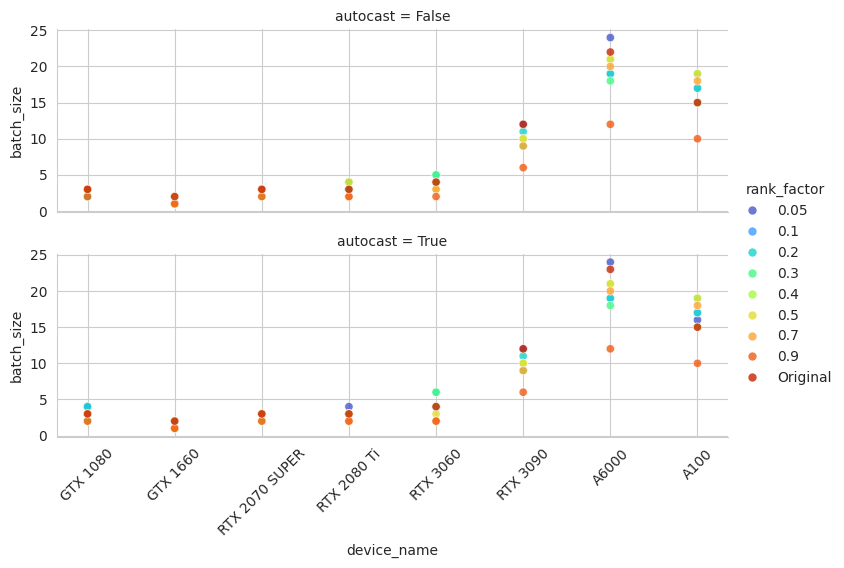

In [4]:
g = sns.relplot(
    data=df_batch,
    x='device_name',
    y='batch_size',
    hue='rank_factor',
    row='autocast',
    palette='turbo',
    alpha=0.8,
    height=2.5,
    aspect=3,
)

plt.xticks(rotation=45)
plt.show()

### Execution times

In [20]:
width = 345

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

In [25]:
def get_size(width, fraction=1):
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

width, height = get_size(397 * 0.8)
print(width, height)

4.394631243946312 2.716031476781052


/tmp/ipykernel_20146/923505765.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sub = df_sub[df['compile'] == False]


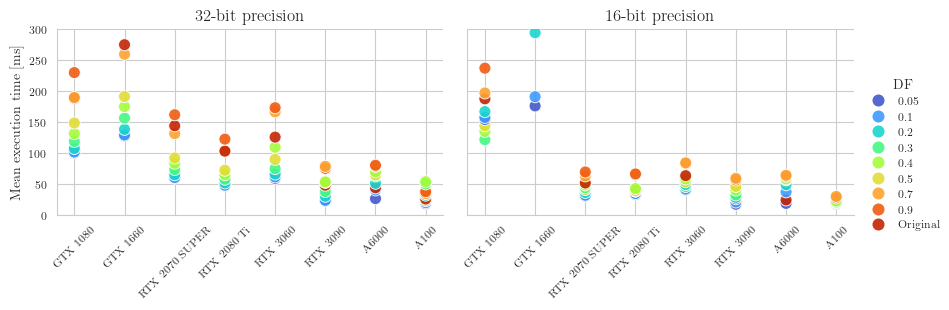

In [37]:
df_sub = df[df['batch_size'] == 1]
df_sub = df_sub[df['compile'] == False]
df_sub = df_sub.sort_values(by='exec_time_mean', ascending=True)

g = sns.relplot(
    data=df_sub,
    x='device_name',
    y='exec_time_mean',
    hue='rank_factor',
    col='autocast',
    palette='turbo',
    alpha=0.9,
    height=height,
    aspect=width/height,
    s=75
)

g.set(ylim=(0, 300))
g._legend.set_title('DF')
g.set_axis_labels('', 'Mean execution time [ms]')

custom_titles = ['32-bit precision', '16-bit precision']
for idx, ax in enumerate(g.axes.flatten()):
    ax.set_title(custom_titles[idx])
    ax.set_xticks(range(len(new_order)))
    ax.set_xticklabels(labels=new_order, rotation=45)

plt.savefig('../results/gpu_benchmark.pdf', bbox_inches='tight')
plt.show()